## Preprocessing Eurosense Coverage Corpus

In [1]:
import re
from lxml import etree
import numpy as np
import glob
import pickle
import numpy as np
import os
import scipy
import itertools
import pandas as pd
from keras.preprocessing import text
from keras.utils import to_categorical 
from keras.preprocessing import sequence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile

Using TensorFlow backend.


In [2]:
def check_punc(word):
    """ Checks if word does not contain only punctuations
    """
    if not re.match(r'^[_\W]+$', word):
        return True
    else:
        return False

In [3]:
file_path = "EuroSense/coverage.xml"
texts_en = [] # Sentences
synset_id_vector = [] # BabelnetId
lemma_vector = [] # Lemma
sense_vector = [] # Anchors
punc_lemma = 0 

def preprocess_eurosense(file_path):
    """ Parse xml file  provided in file_path and returns a sentence,
    babelnetId,lemma and anchors respectively for each sentences
    """
    context = etree.iterparse(file, events=('end',), tag='sentence')
    for event, elem in context:
        synset_id = []
        lemma = []
        sense = []
        try:
            for e in elem.iter():
                if e.tag == "text" and e.attrib.get('lang') == "en" and e.text == None:
                    raise Exception() 
                else:
                  if e.tag == "text" and e.attrib.get('lang') == "en" and e.text != None:
                        texts_en.append(e.text)
                  if e.tag == "annotations":
                    for f in e.iter():
                        if f.tag == "annotation" and f.attrib.get('lang') == "en":
                            l = f.attrib['lemma'].strip()
                            a = f.attrib['anchor'].strip()
                            sid = f.text.strip()
                            if len(l) > 0 and (check_punc(l)== True) and len(a) > 0 and len(sid) == 12:
                              if (l not in lemma) and (a not in sense) and (sid not in synset_id):
                                lemma.append(l)
                                sense.append(a)
                                synset_id.append(sid)
                            else:
                                punc_lemma += 1
            if(len(synset_id) == len(lemma) == len(sense)):     
                synset_id_vector.append(synset_id)
                lemma_vector.append(lemma)
                sense_vector.append(sense)
            else:
             print(synset_id)
             print(lemma)
             print(sense)
        except Exception:
            continue 
        # It's safe to call clear() here because no descendants will be accessed
        elem.clear()
        # Also eliminate now-empty references from the root node to <Title> 
        while elem.getprevious() is not None:
            del elem.getparent()[0]

In [4]:
lemma_synid = [] # Vector of Lemma_synset_id for each sentences
def map_lemma_synsetID(lemma_vector,synset_id_vector):
    """ Concatenates lemma and synsetId for each sentences with '_'
    """
    for lemma,synid in zip(lemma_vector,synset_id_vector):
        syn = []
        for i,j in zip(lemma,synid):
              rep = i.replace(' ','_')+"_"+j
              syn.append(re.sub(r'\b'+re.escape(i)+r'\b', rep, i))
        lemma_synid.append(syn)

In [5]:
coverage_corpus = []
texts_en_copy = texts_en # A copy of all sentences
def replace_anchors(sense_vector,lemma_synid,texts_en_copy):
    """ Replace anchors with lemma_synsetid in sentences
    """
    for j in range(len(sense_vector)):
      for a,b in zip(sense_vector[j],lemma_synid[j]):
        if a in texts_en_copy[j]:
            texts_en_copy[j] = re.sub(r'\b'+re.escape(a)+r'\b', b, texts_en_copy[j])
      coverage_corpus.append(texts_en_copy[j])

## Preprocessing SEW Corpus

In [6]:
texts_en = []
synset_id_vector = []
sense_vector = []

def preprocess_sew(file_path):
  infile = file_path
  punc_lemma = 0
  context = etree.iterparse(infile, events=('end',), tag='wikiArticle',recover=True)
  
  for event, elem in context:
      synset_id = []
      sense = []

      try:
        if elem.attrib.get('language') == "EN":
          for e in elem.iter():
            if e.tag == "text" and e.text == None:
              raise Exception() 
            else:
              if e.tag == "text" and e.text != None:
                texts_en.append(e.text)
              if e.tag == "annotations":
                for f in e.iter():
                  if f.tag == "annotation":

                    for a in f.iter():
                      if a.tag == "babelNetID" and a.text != None:
                        ID = a.text
                      if a.tag == "mention" and a.text != None:
                        mention = a.text

                    if len(mention) > 0 and (check_punc(mention)== True) and len(ID) == 12:
                      if (ID not in synset_id) and (mention not in sense):
                        sense.append(mention)
                        synset_id.append(ID)
                    else:
                        punc_lemma += 1
          if(len(synset_id) == len(sense)):     
            synset_id_vector.append(synset_id)
            sense_vector.append(sense)
          else:
            print("Wrong Length")
      except Exception:
          continue  
    
      elem.clear()
      
      while elem.getprevious() is not None:
          del elem.getparent()[0]

In [7]:
for file in glob.iglob('sew_conservative'+'/**/*xml', recursive=True):
    preprocess_sew(file)

In [8]:
mention_synid = [] # Vector of Lemma_synset_id for each sentences
def map_lemma_synsetID(sense_vector,synset_id_vector):
    for lemma,synid in zip(sense_vector,synset_id_vector):
        syn = []
        for i,j in zip(lemma,synid):
              rep = i.replace(' ','_')+"_"+j
              syn.append(rep)
        mention_synid.append(syn)

In [9]:
sew_corpus = []
texts_en_copy = texts_en # A copy of all sentences
def replace_anchors(sense_vector,mention_synid,texts_en_copy):
    """ Replace anchors with mention_synid in sentences
    """
    for j in range(len(sense_vector)):
      for a,c in zip(sense_vector[j],mention_synid[j]):
        if a in texts_en_copy[j]:
            try:
                texts_en_copy[j] = re.sub(r'\b'+re.escape(a)+r'\b', c, texts_en_copy[j])
            except:
               print(str(a) + " not found")
      sew_corpus.append(texts_en_copy[j])

## Tokenization of SEW and Eurosense Coverage Corpus 

In [10]:
coverage_corpus = [] 
sew_corpus = []
all_dataset = coverage_corpus + sew_corpus
corpus = []
def tokenize_corpus(all_dataset):
    """ Takes a list of all sentences that needs to be tokenized,
    which would be fed into the word2vec model.
    """
    for sentence in all_dataset:
            try:
                corp = text.text_to_word_sequence(sentence,filters='!"#$%&()*+,./;<=>?@[\\]^`{|}~\t\n',split=' ')
                corpus.append(corp)
            except:
                pass

## Word2Vec Model Building and Training

In [11]:
def build_vocabulary(corpus,dimension):
    """ Build vocabulary from corpus given its dimension
    """
    model = Word2Vec(size=dimension,workers = multiprocessing.cpu_count())
    model.build_vocab(corpus)
    model.save("vocab.model")

def train_model(corpus,epoch):
    """ Train word2vec cbow model
    """
    model.train(corpus,total_examples = model.corpus_count,epochs=epoch)
    model.wv.save_word2vec_format('embeddings.vec', binary=False)

## Filtering All Context Embeddings to lemma_synset Embeddings

In [12]:
def load_embedding(file_path):
    """ 
    Takes the file path of the trained word2vec embeddings
    and load into memory.
    """
    with open(file_path) as f:
      embeddings = f.readlines()
      lemma_synset_embedding = []
      for context in embeddings:
        if "_" in context: 
          lemma_synset_embedding.append(context)

In [13]:
dimension = 400 # Vector dimension that was used to train the word2vec model
def save_embedding(file_path):
    """ Takes the file path of where you want to save the lemma_synset embeddings
    and saves it to the disk.
    """
    with open('embeddings_lemma_id.vec','w') as f:
      f.write(str(len(lemma_synset_embedding)) + " "+str(dimension)+"\n")
      for s in lemma_synset_embedding:
        f.write(s.strip())
        f.write("\n")
    print("Done writing lemma_synset embeddings to "+file_path)

In [14]:
# Usage of the above functions
load_embedding("best_embeddings_400_30.vec")
save_embedding("embeddings_lemma_id.vec")

## Visualizations

In [2]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('embeddings_lemma_id.vec', binary=False) # Load trained sense embeddings

In [3]:
keys = ['polarise_bn:00091814v', 'dispersal_bn:03697298n', 'strangers_bn:02762388n','arabian_bn:02289259n','reunion_bn:03591840n','crusaders_bn:03178830n']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=50):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [96]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

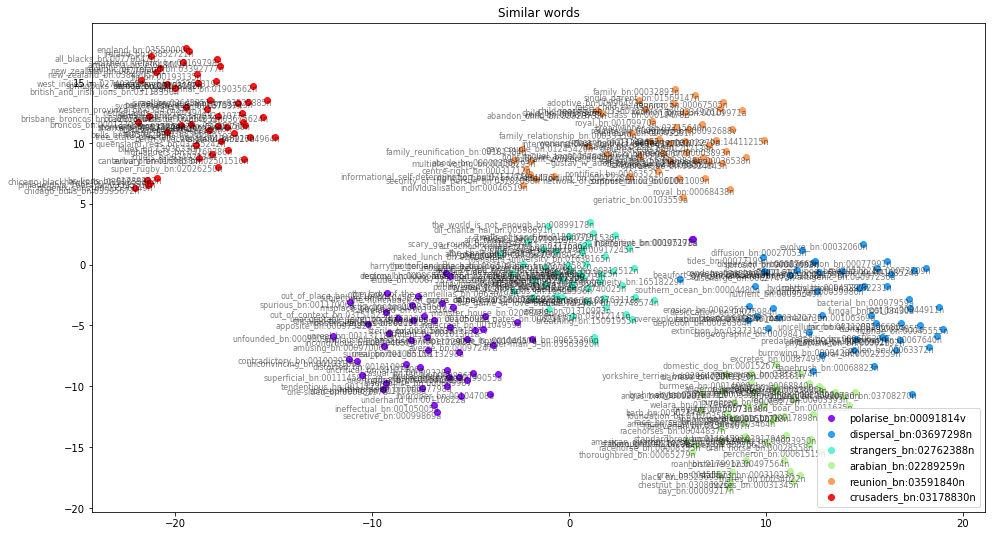

In [97]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='top', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.9,
                        'word_vic.png')

In [8]:
from sklearn.manifold import TSNE
import numpy as np

words_wp = []
embeddings_wp = []
for word in list(model.wv.vocab):
    embeddings_wp.append(model.wv[word])
    words_wp.append(word)
    
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp[:5000])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


/usr/lib/python3/dist-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


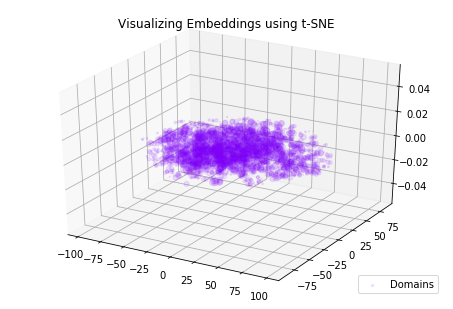

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Domains', embeddings_wp_3d, a=0.1)

## Word Similarity Task
* In order to perform this task with sense embeddings you have to:
* For each pair w1 , w2
    * S1 = all sense embeddings associated with word w1
    * S2 = all sense embeddings associated with word w2
    * score = - 1.0
    * For each pair s1 in S1 and s2 in S2 do
        * score = max(score, cos( s1, s2 ) ) 
        
(cos == cosine similarity of two vectors)

In [2]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('embeddings_lemma_id.vec', binary=False) # Load trained sense embeddings

In [16]:
# Load vectors as dictionaries
vocab = model.wv.vocab
dictionary = list(vocab.keys())
print("dictionary size is: {}".format(len(dictionary)))

dictionary size is: 261287


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [17]:
def load_sense_embeddings(word):
    '''returns the sense embeddings for a given word'''
    
    word = word.split()
    word = "_".join(word) if len(word)>1 else  word[0]
    wordSenses = []
    
    for w in dictionary:
        newWord = w.split(":")
        newWord = newWord[0].split("_")
        newWord = "_".join(newWord[:-1])
        if word.lower() == newWord.lower():
            wordSenses.append(w)
    
    return wordSenses

In [18]:
def word_similarity(w1, w2):
    '''take two words and outputs a score of their similarity'''
    w1_senses = load_sense_embeddings(w1)
    w2_senses = load_sense_embeddings(w2)
    score = - 1.0
    
    if len(w1_senses)!=0 and len(w2_senses)!=0:
        combinations = itertools.product(w1_senses,w2_senses)
        for s1, s2 in combinations:
            score = max(score, model.wv.similarity(s1, s2))
            
    return score

In [19]:
def get_spearman_correlation(file_path):
    gold = pd.read_csv(file_path, delimiter = '\t')
    gold['cosine'] = gold.apply(lambda row: word_similarity(row['Word 1'],row['Word 2']),axis=1)
    correlation, _ = scipy.stats.spearmanr(gold['Human (mean)'], gold['cosine'])
    return correlation

In [20]:
print("Spearman correlation: " +str(get_spearman_correlation('combined.tab')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


Spearman correlation: 0.5228448017606238
